In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
import torch
import torch.optim as optim
from utils import *
from tqdm import tqdm
import random

plt.rc('font', family='AppleGothic') 

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(0)

# 데이터 불러오기 및 전처리

In [19]:
df = pd.read_csv('feature_extraction.csv')

In [20]:
ACC_LIST = [i for i in range(2, 38)]
AE_LIST = [i for i in range(38, 50)]
FORCE_LIST = [i for i in range(50, 86)]

X_ACAE = df.iloc[:, ACC_LIST + AE_LIST].values
X_ACF = df.iloc[:, ACC_LIST + FORCE_LIST].values
X_AEF = df.iloc[:, AE_LIST + FORCE_LIST].values

X = df.iloc[:, ACC_LIST + AE_LIST + FORCE_LIST].values
y = df.iloc[:, -1].values

# Milling Condition 에 따른 데이터 나누기
t1_to_t4_indices = [i for i in range(0, 12*4)]
t5_indices = [i for i in range(12*4, 12*5)]
t6_indices = [i for i in range(12*5, 12*6)]
t7_indices = [i for i in range(12*6, 12*7)]
t8_indices = [i for i in range(12*7, 12*8)]

X_train = X_ACF[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACF[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)


In [21]:
def result_of_T5toT8(model, X, y):
    model_type = 'Distilled LSTM'
    X_train = X[t1_to_t4_indices].copy()
    y_train = y[t1_to_t4_indices].copy()

    normalizer = Normalize()
    X_train, y_train = normalizer.fit_transform(X_train, y_train)

    y_pred_train = model.predict(X_train)

    y_train_original = normalizer.inverse_normalize_data(y_train)
    y_pred_train_original = normalizer.inverse_normalize_data(y_pred_train)
    print(f'{model_type} Train RMSE: ', np.sqrt(mean_squared_error(y_train_original, y_pred_train_original)))
    print(f'{model_type} Train R2: ', r2_score(y_train_original, y_pred_train_original))

    # T5 결과
    X_test = X[t5_indices].copy()
    y_test = y[t5_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T5: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T5: ', r2_score(y_test_original, y_pred_test_original))
    t5_results = (y_test_original, y_pred_test_original)

    # T6 결과
    X_test = X[t6_indices].copy()
    y_test = y[t6_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T6: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T6: ', r2_score(y_test_original, y_pred_test_original))
    t6_results = (y_test_original, y_pred_test_original)

    # T7 결과
    X_test = X[t7_indices].copy()
    y_test = y[t7_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T7: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T7: ', r2_score(y_test_original, y_pred_test_original))
    t7_results = (y_test_original, y_pred_test_original)

    # T8 결과
    X_test = X[t8_indices].copy()
    y_test = y[t8_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T8: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T8: ', r2_score(y_test_original, y_pred_test_original))
    t8_results = (y_test_original, y_pred_test_original)

    results = {
        'T5': t5_results,
        'T6': t6_results,
        'T7': t7_results,
        'T8': t8_results,
        'model': model,
    }

    return results


# Teacher model & Student model 정의

In [22]:
class _LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(_LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class LSTM_Model:
    def __init__(self, input_size, hidden_size, num_layers, output_size, learning_rate, gradient_threshold, epoch):
        self.model = _LSTMModel(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.1)
        self.epoch = epoch
        self.gradient_threshold = gradient_threshold

    def train(self, X_train, y_train):
        print('LSTM Training')
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
        
        self.model.train()
        for epoch in tqdm(range(self.epoch)):
            outputs = self.model(X_train_tensor)
            loss = self.criterion(outputs, y_train_tensor)
            
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_threshold)
            
            self.optimizer.step()
            
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.epoch}], Loss: {loss.item():.4f}')
            
            # self.scheduler.step()
        
        print('LSTM Training Done')

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor).detach().numpy()
        return y_pred

    def save_model(self, path):
        torch.save(self.model.state_dict(), f'{path}.pth')
        print("모델 상태 저장 완료")


In [23]:
# 지식 증류 함수
def distillation_loss(student_output, teacher_output, true_labels, alpha):
    loss_fn = nn.MSELoss()
    distillation_loss = loss_fn(student_output, teacher_output)
    student_loss = loss_fn(student_output, true_labels)
    return alpha * distillation_loss + (1 - alpha) * student_loss

# 학생 모델 학습
class DistilledLSTMModel:
    def __init__(self, teacher_model, input_size, hidden_size, num_layers, output_size, learning_rate, gradient_threshold, epoch, alpha):
        self.teacher_model = teacher_model
        self.model = _LSTMModel(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.1)
        self.epoch = epoch
        self.gradient_threshold = gradient_threshold
        self.alpha = alpha

    def train(self, X_train, y_train):
        print('Distilled LSTM Training')
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
        
        self.teacher_model.eval()
        self.model.train()
        for epoch in tqdm(range(self.epoch)):
            student_outputs = self.model(X_train_tensor)
            with torch.no_grad():
                teacher_outputs = self.teacher_model(X_train_tensor)
            
            loss = distillation_loss(student_outputs, teacher_outputs, y_train_tensor, self.alpha)
            
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_threshold)
            
            self.optimizer.step()
            
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.epoch}], Loss: {loss.item():.4f}')
            
            # self.scheduler.step()
        
        print('Distilled LSTM Training Done')

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor).detach().numpy()
        return y_pred

    def save_model(self, path):
        torch.save(self.model.state_dict(), f'{path}.pth')
        print("학생 모델 상태 저장 완료")

# Teacher model 불러오기

In [24]:
teacher_params = {
    'input_size': 1,
    'num_layers': 3,
    'hidden_size': 100,
    'epoch': 200, # 100
    'gradient_threshold': 0.5, # 0.5
    'output_size': 1,
    'learning_rate': 0.01
}
teacher_model = LSTM_Model(**teacher_params)
teacher_model.model.load_state_dict(torch.load('lstm_acf_model.pth'))
teacher_model = teacher_model.model

# Student model 실험

In [25]:
# 50, 3
# alpha: 0.5
input_size = 1
hidden_size = 50  
num_layers = 3 
output_size = 1
learning_rate = 0.001
gradient_threshold = 0.5
epoch = 300
alpha = 0.5

distilled_model = DistilledLSTMModel(teacher_model, input_size, hidden_size, num_layers, output_size, learning_rate, gradient_threshold, epoch, alpha)
distilled_model.train(X_train, y_train)
results = result_of_T5toT8(distilled_model, X_ACF, y)

Distilled LSTM Training


  4%|▎         | 11/300 [00:01<00:38,  7.54it/s]

Epoch [10/300], Loss: 0.0844


  7%|▋         | 21/300 [00:02<00:44,  6.25it/s]

Epoch [20/300], Loss: 0.0490


 10%|█         | 31/300 [00:04<00:36,  7.36it/s]

Epoch [30/300], Loss: 0.0483


 14%|█▎        | 41/300 [00:05<00:36,  7.10it/s]

Epoch [40/300], Loss: 0.0460


 17%|█▋        | 51/300 [00:06<00:31,  7.93it/s]

Epoch [50/300], Loss: 0.0453


 20%|██        | 61/300 [00:08<00:31,  7.63it/s]

Epoch [60/300], Loss: 0.0452


 24%|██▎       | 71/300 [00:09<00:30,  7.60it/s]

Epoch [70/300], Loss: 0.0452


 27%|██▋       | 81/300 [00:11<00:33,  6.58it/s]

Epoch [80/300], Loss: 0.0452


 30%|███       | 91/300 [00:13<00:43,  4.76it/s]

Epoch [90/300], Loss: 0.0452


 34%|███▎      | 101/300 [00:14<00:26,  7.47it/s]

Epoch [100/300], Loss: 0.0451


 37%|███▋      | 111/300 [00:15<00:24,  7.74it/s]

Epoch [110/300], Loss: 0.0451


 40%|████      | 120/300 [00:17<00:33,  5.42it/s]

Epoch [120/300], Loss: 0.0450


 44%|████▎     | 131/300 [00:18<00:22,  7.51it/s]

Epoch [130/300], Loss: 0.0449


 47%|████▋     | 141/300 [00:20<00:20,  7.59it/s]

Epoch [140/300], Loss: 0.0446


 50%|█████     | 151/300 [00:21<00:18,  7.88it/s]

Epoch [150/300], Loss: 0.0443


 54%|█████▎    | 161/300 [00:22<00:20,  6.71it/s]

Epoch [160/300], Loss: 0.0441


 57%|█████▋    | 171/300 [00:24<00:16,  7.75it/s]

Epoch [170/300], Loss: 0.0438


 60%|██████    | 181/300 [00:25<00:15,  7.93it/s]

Epoch [180/300], Loss: 0.0435


 64%|██████▎   | 191/300 [00:26<00:13,  7.89it/s]

Epoch [190/300], Loss: 0.0429


 67%|██████▋   | 201/300 [00:28<00:12,  7.71it/s]

Epoch [200/300], Loss: 0.0412


 70%|███████   | 211/300 [00:29<00:11,  7.54it/s]

Epoch [210/300], Loss: 0.0403


 74%|███████▎  | 221/300 [00:31<00:10,  7.33it/s]

Epoch [220/300], Loss: 0.0396


 77%|███████▋  | 231/300 [00:32<00:09,  6.98it/s]

Epoch [230/300], Loss: 0.0386


 80%|████████  | 241/300 [00:33<00:07,  7.54it/s]

Epoch [240/300], Loss: 0.0376


 84%|████████▎ | 251/300 [00:35<00:06,  7.82it/s]

Epoch [250/300], Loss: 0.0369


 87%|████████▋ | 261/300 [00:36<00:05,  6.94it/s]

Epoch [260/300], Loss: 0.0364


 90%|█████████ | 271/300 [00:37<00:03,  7.61it/s]

Epoch [270/300], Loss: 0.0358


 94%|█████████▎| 281/300 [00:39<00:02,  8.06it/s]

Epoch [280/300], Loss: 0.0352


 97%|█████████▋| 291/300 [00:40<00:01,  7.92it/s]

Epoch [290/300], Loss: 0.0349


100%|██████████| 300/300 [00:41<00:00,  7.22it/s]


Epoch [300/300], Loss: 0.0345
Distilled LSTM Training Done
Distilled LSTM Train RMSE:  55.50454893553572
Distilled LSTM Train R2:  0.3487444002456991
Distilled LSTM Test RMSE of T5:  56.87221795940873
Distilled LSTM Test R2 of T5:  0.31625423956229437
Distilled LSTM Test RMSE of T6:  85.1502467324366
Distilled LSTM Test R2 of T6:  -0.532731689752137
Distilled LSTM Test RMSE of T7:  61.427909823814296
Distilled LSTM Test R2 of T7:  0.2023253483326447
Distilled LSTM Test RMSE of T8:  51.39390455635933
Distilled LSTM Test R2 of T8:  0.44163582929900635


In [26]:
# 100, 2
# alpha: 0.5
input_size = 1
hidden_size = 100 
num_layers = 2
output_size = 1
learning_rate = 0.001
gradient_threshold = 0.5
epoch = 300
alpha = 0.5

distilled_model = DistilledLSTMModel(teacher_model, input_size, hidden_size, num_layers, output_size, learning_rate, gradient_threshold, epoch, alpha)
distilled_model.train(X_train, y_train)
results = result_of_T5toT8(distilled_model, X_ACF, y)

Distilled LSTM Training


  4%|▎         | 11/300 [00:01<00:34,  8.32it/s]

Epoch [10/300], Loss: 0.0508


  7%|▋         | 21/300 [00:02<00:35,  7.82it/s]

Epoch [20/300], Loss: 0.0474


 10%|█         | 31/300 [00:03<00:31,  8.46it/s]

Epoch [30/300], Loss: 0.0453


 14%|█▎        | 41/300 [00:05<00:30,  8.57it/s]

Epoch [40/300], Loss: 0.0454


 17%|█▋        | 51/300 [00:06<00:29,  8.51it/s]

Epoch [50/300], Loss: 0.0454


 20%|██        | 61/300 [00:07<00:27,  8.67it/s]

Epoch [60/300], Loss: 0.0452


 24%|██▎       | 71/300 [00:08<00:26,  8.49it/s]

Epoch [70/300], Loss: 0.0452


 27%|██▋       | 81/300 [00:09<00:24,  8.88it/s]

Epoch [80/300], Loss: 0.0451


 30%|███       | 91/300 [00:11<00:25,  8.08it/s]

Epoch [90/300], Loss: 0.0450


 34%|███▎      | 101/300 [00:12<00:22,  8.98it/s]

Epoch [100/300], Loss: 0.0449


 37%|███▋      | 111/300 [00:13<00:20,  9.08it/s]

Epoch [110/300], Loss: 0.0446


 40%|████      | 121/300 [00:14<00:20,  8.75it/s]

Epoch [120/300], Loss: 0.0440


 44%|████▎     | 131/300 [00:15<00:20,  8.13it/s]

Epoch [130/300], Loss: 0.0438


 47%|████▋     | 141/300 [00:16<00:17,  8.98it/s]

Epoch [140/300], Loss: 0.0436


 50%|█████     | 151/300 [00:18<00:15,  9.33it/s]

Epoch [150/300], Loss: 0.0432


 54%|█████▎    | 161/300 [00:19<00:15,  8.87it/s]

Epoch [160/300], Loss: 0.0423


 57%|█████▋    | 171/300 [00:20<00:14,  8.99it/s]

Epoch [170/300], Loss: 0.0408


 60%|██████    | 181/300 [00:21<00:13,  8.82it/s]

Epoch [180/300], Loss: 0.0397


 64%|██████▎   | 191/300 [00:22<00:12,  9.03it/s]

Epoch [190/300], Loss: 0.0392


 67%|██████▋   | 201/300 [00:23<00:11,  8.78it/s]

Epoch [200/300], Loss: 0.0385


 70%|███████   | 211/300 [00:24<00:10,  8.90it/s]

Epoch [210/300], Loss: 0.0380


 74%|███████▎  | 221/300 [00:25<00:08,  8.82it/s]

Epoch [220/300], Loss: 0.0375


 77%|███████▋  | 231/300 [00:27<00:07,  9.08it/s]

Epoch [230/300], Loss: 0.0386


 80%|████████  | 241/300 [00:28<00:06,  8.87it/s]

Epoch [240/300], Loss: 0.0379


 84%|████████▎ | 251/300 [00:29<00:05,  9.03it/s]

Epoch [250/300], Loss: 0.0375


 87%|████████▋ | 261/300 [00:30<00:04,  8.28it/s]

Epoch [260/300], Loss: 0.0368


 90%|█████████ | 271/300 [00:31<00:03,  8.96it/s]

Epoch [270/300], Loss: 0.0366


 94%|█████████▎| 281/300 [00:32<00:02,  9.13it/s]

Epoch [280/300], Loss: 0.0361


 97%|█████████▋| 291/300 [00:33<00:00,  9.22it/s]

Epoch [290/300], Loss: 0.0357


100%|██████████| 300/300 [00:34<00:00,  8.62it/s]


Epoch [300/300], Loss: 0.0354
Distilled LSTM Training Done
Distilled LSTM Train RMSE:  56.57932284425256
Distilled LSTM Train R2:  0.32327876262009747
Distilled LSTM Test RMSE of T5:  55.99007709232226
Distilled LSTM Test R2 of T5:  0.33730080019381625
Distilled LSTM Test RMSE of T6:  80.32295190374445
Distilled LSTM Test R2 of T6:  -0.36387207210418526
Distilled LSTM Test RMSE of T7:  66.77839694334165
Distilled LSTM Test R2 of T7:  0.0573156570992166
Distilled LSTM Test RMSE of T8:  52.591606355744005
Distilled LSTM Test R2 of T8:  0.41530795187956326


In [29]:
# 100, 2
# alpha: 0.3
input_size = 1
hidden_size = 100 
num_layers = 2
output_size = 1
learning_rate = 0.001
gradient_threshold = 0.5
epoch = 300
alpha = 0.3

distilled_model = DistilledLSTMModel(teacher_model, input_size, hidden_size, num_layers, output_size, learning_rate, gradient_threshold, epoch, alpha)
distilled_model.train(X_train, y_train)
results = result_of_T5toT8(distilled_model, X_ACF, y)

Distilled LSTM Training


  4%|▎         | 11/300 [00:01<00:37,  7.61it/s]

Epoch [10/300], Loss: 0.0711


  7%|▋         | 21/300 [00:02<00:40,  6.91it/s]

Epoch [20/300], Loss: 0.0695


 10%|█         | 31/300 [00:04<00:33,  7.93it/s]

Epoch [30/300], Loss: 0.0647


 14%|█▎        | 41/300 [00:05<00:35,  7.31it/s]

Epoch [40/300], Loss: 0.0637


 17%|█▋        | 51/300 [00:07<00:46,  5.34it/s]

Epoch [50/300], Loss: 0.0633


 20%|██        | 61/300 [00:08<00:32,  7.30it/s]

Epoch [60/300], Loss: 0.0632


 24%|██▎       | 71/300 [00:10<00:50,  4.50it/s]

Epoch [70/300], Loss: 0.0631


 27%|██▋       | 81/300 [00:11<00:29,  7.39it/s]

Epoch [80/300], Loss: 0.0630


 30%|███       | 91/300 [00:13<00:26,  7.99it/s]

Epoch [90/300], Loss: 0.0628


 34%|███▎      | 101/300 [00:14<00:26,  7.45it/s]

Epoch [100/300], Loss: 0.0626


 37%|███▋      | 111/300 [00:15<00:23,  7.91it/s]

Epoch [110/300], Loss: 0.0620


 40%|████      | 121/300 [00:16<00:25,  7.09it/s]

Epoch [120/300], Loss: 0.0610


 44%|████▎     | 131/300 [00:18<00:21,  7.81it/s]

Epoch [130/300], Loss: 0.0605


 47%|████▋     | 141/300 [00:19<00:20,  7.94it/s]

Epoch [140/300], Loss: 0.0599


 50%|█████     | 151/300 [00:20<00:18,  7.99it/s]

Epoch [150/300], Loss: 0.0587


 54%|█████▎    | 161/300 [00:22<00:33,  4.11it/s]

Epoch [160/300], Loss: 0.0563


 57%|█████▋    | 171/300 [00:24<00:18,  7.05it/s]

Epoch [170/300], Loss: 0.0539


 60%|██████    | 181/300 [00:25<00:15,  7.89it/s]

Epoch [180/300], Loss: 0.0527


 64%|██████▎   | 191/300 [00:26<00:12,  8.73it/s]

Epoch [190/300], Loss: 0.0510


 67%|██████▋   | 201/300 [00:28<00:12,  7.89it/s]

Epoch [200/300], Loss: 0.0498


 70%|███████   | 211/300 [00:29<00:11,  8.05it/s]

Epoch [210/300], Loss: 0.0485


 74%|███████▎  | 221/300 [00:30<00:10,  7.20it/s]

Epoch [220/300], Loss: 0.0486


 77%|███████▋  | 231/300 [00:32<00:09,  7.37it/s]

Epoch [230/300], Loss: 0.0478


 80%|████████  | 240/300 [00:33<00:07,  8.23it/s]

Epoch [240/300], Loss: 0.0468


 84%|████████▎ | 251/300 [00:35<00:08,  5.92it/s]

Epoch [250/300], Loss: 0.0480


 87%|████████▋ | 260/300 [00:36<00:05,  7.10it/s]

Epoch [260/300], Loss: 0.0470


 90%|█████████ | 271/300 [00:38<00:03,  8.46it/s]

Epoch [270/300], Loss: 0.0443


 94%|█████████▎| 281/300 [00:39<00:02,  8.78it/s]

Epoch [280/300], Loss: 0.0434


 97%|█████████▋| 291/300 [00:40<00:01,  7.73it/s]

Epoch [290/300], Loss: 0.0414


100%|██████████| 300/300 [00:41<00:00,  7.20it/s]


Epoch [300/300], Loss: 0.0386
Distilled LSTM Training Done
Distilled LSTM Train RMSE:  47.92867995805995
Distilled LSTM Train R2:  0.5143926504499033
Distilled LSTM Test RMSE of T5:  56.13143947112123
Distilled LSTM Test R2 of T5:  0.33395024232356885
Distilled LSTM Test RMSE of T6:  76.86462271160559
Distilled LSTM Test R2 of T6:  -0.24895650655427115
Distilled LSTM Test RMSE of T7:  77.0169015296882
Distilled LSTM Test R2 of T7:  -0.2539100992248695
Distilled LSTM Test RMSE of T8:  47.42344217299169
Distilled LSTM Test R2 of T8:  0.5245766999327783


In [31]:
# 50, 3
# alpha: 0.3
input_size = 1
hidden_size = 50  
num_layers = 3 
output_size = 1
learning_rate = 0.001
gradient_threshold = 0.5
epoch = 300
alpha = 0.3

distilled_model = DistilledLSTMModel(teacher_model, input_size, hidden_size, num_layers, output_size, learning_rate, gradient_threshold, epoch, alpha)
distilled_model.train(X_train, y_train)
results = result_of_T5toT8(distilled_model, X_ACF, y)

Distilled LSTM Training


  4%|▎         | 11/300 [00:01<00:38,  7.51it/s]

Epoch [10/300], Loss: 0.0938


  7%|▋         | 21/300 [00:02<00:32,  8.69it/s]

Epoch [20/300], Loss: 0.0641


 10%|█         | 31/300 [00:04<00:32,  8.38it/s]

Epoch [30/300], Loss: 0.0656


 14%|█▎        | 41/300 [00:05<00:31,  8.25it/s]

Epoch [40/300], Loss: 0.0643


 17%|█▋        | 51/300 [00:06<00:30,  8.22it/s]

Epoch [50/300], Loss: 0.0635


 20%|██        | 61/300 [00:07<00:27,  8.60it/s]

Epoch [60/300], Loss: 0.0633


 24%|██▎       | 71/300 [00:08<00:26,  8.69it/s]

Epoch [70/300], Loss: 0.0633


 27%|██▋       | 81/300 [00:10<00:26,  8.32it/s]

Epoch [80/300], Loss: 0.0632


 30%|███       | 91/300 [00:11<00:24,  8.55it/s]

Epoch [90/300], Loss: 0.0632


 34%|███▎      | 101/300 [00:12<00:23,  8.36it/s]

Epoch [100/300], Loss: 0.0631


 37%|███▋      | 111/300 [00:13<00:21,  8.67it/s]

Epoch [110/300], Loss: 0.0631


 40%|████      | 121/300 [00:14<00:20,  8.79it/s]

Epoch [120/300], Loss: 0.0629


 44%|████▎     | 131/300 [00:15<00:19,  8.52it/s]

Epoch [130/300], Loss: 0.0627


 47%|████▋     | 141/300 [00:17<00:18,  8.45it/s]

Epoch [140/300], Loss: 0.0621


 50%|█████     | 151/300 [00:18<00:17,  8.35it/s]

Epoch [150/300], Loss: 0.0612


 54%|█████▎    | 161/300 [00:19<00:16,  8.26it/s]

Epoch [160/300], Loss: 0.0606


 57%|█████▋    | 171/300 [00:20<00:14,  8.75it/s]

Epoch [170/300], Loss: 0.0594


 60%|██████    | 181/300 [00:21<00:13,  8.98it/s]

Epoch [180/300], Loss: 0.0562


 64%|██████▎   | 191/300 [00:22<00:12,  8.61it/s]

Epoch [190/300], Loss: 0.0533


 67%|██████▋   | 201/300 [00:24<00:10,  9.04it/s]

Epoch [200/300], Loss: 0.0512


 70%|███████   | 211/300 [00:25<00:09,  9.38it/s]

Epoch [210/300], Loss: 0.0495


 74%|███████▎  | 221/300 [00:26<00:09,  8.53it/s]

Epoch [220/300], Loss: 0.0482


 77%|███████▋  | 231/300 [00:27<00:07,  8.79it/s]

Epoch [230/300], Loss: 0.0459


 80%|████████  | 241/300 [00:28<00:06,  8.77it/s]

Epoch [240/300], Loss: 0.0440


 84%|████████▎ | 251/300 [00:29<00:05,  8.22it/s]

Epoch [250/300], Loss: 0.0436


 87%|████████▋ | 261/300 [00:30<00:04,  8.23it/s]

Epoch [260/300], Loss: 0.0417


 90%|█████████ | 271/300 [00:32<00:03,  8.93it/s]

Epoch [270/300], Loss: 0.0386


 94%|█████████▎| 281/300 [00:33<00:02,  9.16it/s]

Epoch [280/300], Loss: 0.0463


 97%|█████████▋| 291/300 [00:34<00:01,  8.61it/s]

Epoch [290/300], Loss: 0.0369


100%|██████████| 300/300 [00:35<00:00,  8.48it/s]


Epoch [300/300], Loss: 0.0360
Distilled LSTM Training Done
Distilled LSTM Train RMSE:  46.67654910213975
Distilled LSTM Train R2:  0.5394340832699337
Distilled LSTM Test RMSE of T5:  49.578052475267384
Distilled LSTM Test R2 of T5:  0.48039509646835443
Distilled LSTM Test RMSE of T6:  65.0416242713924
Distilled LSTM Test R2 of T6:  0.10571268246337817
Distilled LSTM Test RMSE of T7:  71.59874122069343
Distilled LSTM Test R2 of T7:  -0.08369005858449308
Distilled LSTM Test RMSE of T8:  33.682380098457195
Distilled LSTM Test R2 of T8:  0.7601720141186785


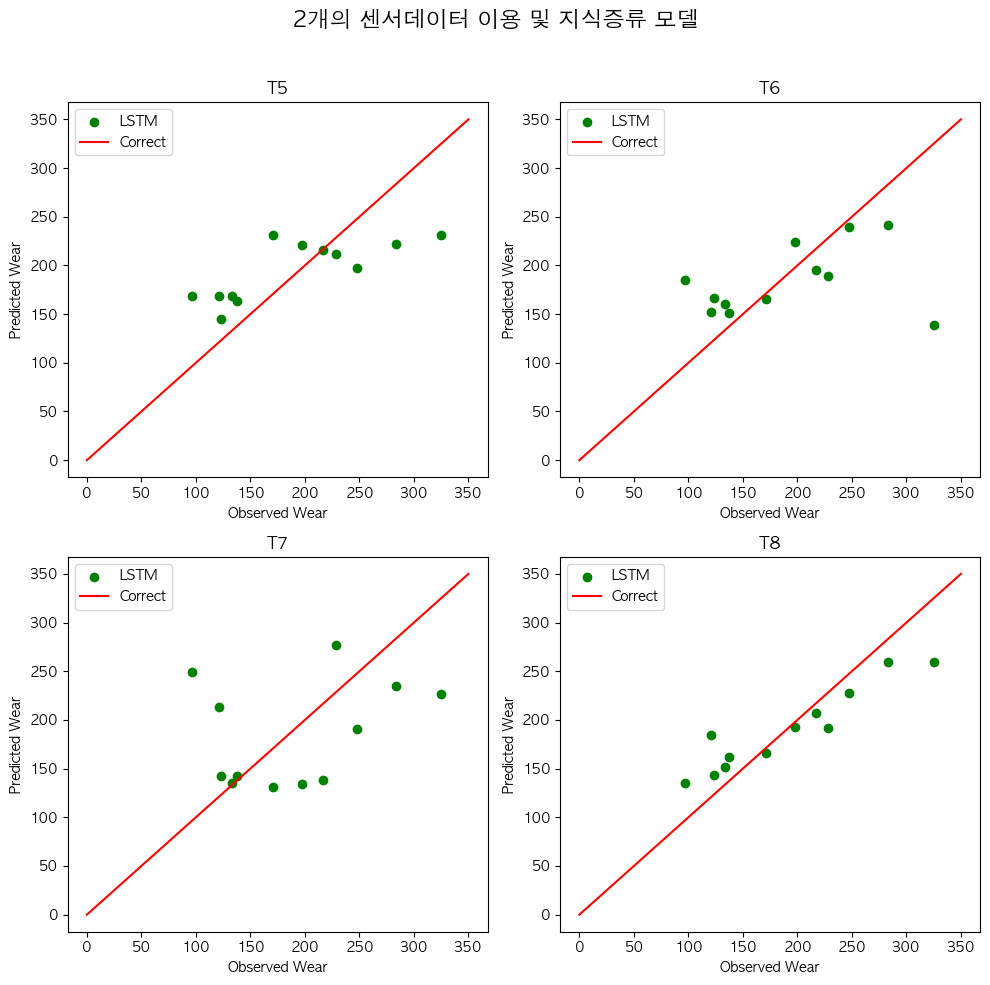

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    # axs[i].scatter(svr_all_results[f'T{i+5}'][0], svr_all_results[f'T{i+5}'][1], label='SVR', color='blue')
    # axs[i].scatter(rfr_all_results[f'T{i+5}'][0], rfr_all_results[f'T{i+5}'][1], label='RFR', color='red')
    axs[i].scatter(results[f'T{i+5}'][0], results[f'T{i+5}'][1], label='LSTM', color='green')
    axs[i].plot([0, 350], [0, 350], 'r-', label='Correct')
    axs[i].set_xlabel('Observed Wear')
    axs[i].set_ylabel('Predicted Wear')
    axs[i].legend()
    axs[i].set_title(f'T{i+5}')

fig.suptitle('2개의 센서데이터 이용 및 지식증류 모델', fontsize=16)
# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 그래프 출력
plt.show()

In [34]:
# 모델 저장
# param: hidden_size: 50, layer: 3, alpha: 0.3
distilled_model.save_model('distilled_lstm_acf_model')


학생 모델 상태 저장 완료
